In [1]:
## calculate ROC responses of neurons

import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style
style.use('ggplot')
import matplotlib.gridspec as gridspec

from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
import yaml

import import_ipynb
import func_analysis
import func_behavclass
import func_plot
import func_format

np.set_printoptions(precision = 3, suppress = True)

import warnings
warnings.filterwarnings('ignore')

from glob import glob
import shutil

importing Jupyter notebook from func_analysis.ipynb
importing Jupyter notebook from func_behavclass.ipynb
importing Jupyter notebook from func_plot.ipynb
importing Jupyter notebook from func_format.ipynb


In [2]:
def run_roc(savepath, drive, ratID, date, neuronpath):

    configpath = drive+ratID+'/Parameters_'+date+'.yml'

    func_format.foldercheck(savepath)

    [foldername, inttype, intcat, presentationnum, videosync_start, videosync_stop, framerate, framestouse, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    colorscheme = {'Male': 'blue', 'Object': 'purple', 'Food': 'orange', 'Female': 'red'}

    firstrow = np.hstack(('Neuron ID', foldername))
    output = firstrow
    output2 = firstrow

    for i, neuron in enumerate(os.listdir(neuronpath)):
        allbasefr = []
        allintfr = []
        if neuron[-4:] == '.npy':
            spiketimes = np.load(neuronpath+neuron)/1000
        else:
            continue
        neuronname = neuron[:-4]
        neuronresults = neuronname
        neuronresults2 = neuronname
        allfr = func_analysis.firingrate(spiketimes, 1, spiketimes[0], spiketimes[-1], smooth=False)

        ### extract baseline firing - 300s before interaction start --> 10s before
        basestart =np.ravel(intsync_start)-300
        basestop = np.ravel(intsync_start)-10
        for x, time in enumerate(basestart):
            basespikes = func_analysis.extractSpikes(spiketimes, basestart[x], basestop[x])
            basefr = func_analysis.firingrate(basespikes, 1, basestart[x], basestop[x], smooth=False)
            allbasefr = np.hstack((allbasefr, basefr))
            
        for y, time in enumerate(np.ravel(intsync_start)):
            intspikes = func_analysis.extractSpikes(spiketimes, intsync_start[y], intsync_stop[y])
            intfr = func_analysis.firingrate(intspikes, 1, intsync_start[y], intsync_stop[y], smooth=False)
            allintfr = np.hstack((allintfr, intfr))
            
        combinedfr = np.hstack((allbasefr, allintfr))

        ##calculate random auROC distribution for this neuron
        #auROC_distribution = []
        #for j in range(1000):
            #randombasefr = np.random.choice(combinedfr, 300, replace=False)
            #randomintfr = np.random.choice(combinedfr, 300, replace=False)
            #[auROC_random, xxx, xxxx] = func_analysis.calcROC(randombasefr, randomintfr)
            #auROC_distribution = np.append(auROC_distribution, auROC_random)

        #upperlimit = np.nanmean(auROC_distribution)+np.nanstd(auROC_distribution)*3
        #lowerlimit = np.nanmean(auROC_distribution)-np.nanstd(auROC_distribution)*3

        ##calculate actual ROC score from interaction
        for l, folder in enumerate(foldername):
            color = colorscheme[intcat[l]]
            intstart = intsync_start[l]
            intstop = intsync_stop[l]
            basestart = intstart-300
            basestop = intstart-10
            
            intspikes = func_analysis.extractSpikes(spiketimes, intstart, intstop)
            intfr = func_analysis.firingrate(intspikes, 1, intstart, intstop, smooth=False)
            basespikes = func_analysis.extractSpikes(spiketimes, basestart, basestop)
            basefr = func_analysis.firingrate(basespikes, 1, basestart, basestop, smooth=False)

            ##neuronspike count threshold for calculating (50spikes/~5min = 10spikes per minute for now)
            ##there are neurons that decrease their firing drastically upon presentation of stimulus
            
            if len(intspikes) < 50 and np.max(intfr) < 2:
                auROC = 'nan'
                sig = 'nan'
                neuronresults = np.append(neuronresults, auROC)
                neuronresults2 = np.append(neuronresults2, sig)
                continue

            [auROC, fpr, tpr] = func_analysis.calcROC(allbasefr, intfr)
            [auROC2, fpr2, tpr2] = func_analysis.calcROC(basefr, intfr)

            ### plot ROC
            bins = np.arange(0, np.max(np.hstack((allbasefr, intfr))), 1)
            plt.close()
            fig, ax = plt.subplots(1, 2, figsize = (4, 2))
            ax1 = ax[0]
            ax1.hist(allbasefr, alpha=0.5, bins=bins, density=True, color='k', histtype='stepfilled')
            ax1.hist(intfr, alpha=0.75, bins=bins, density=True, color=color, histtype='stepfilled')
            ax1.set_title('Firing \nDistributions', fontsize=10)

            ax2=ax[1]
            ax2.plot([0,1],[0,1], color='k', linestyle='dashed', alpha=0.5)
            ax2.plot(fpr,tpr, color=color)
            ax2.set_xlim(-.05,1.05)
            ax2.set_ylim(-.05,1.05)
            ax2.set_title('ROC Curve \nauROC'+str(np.round(auROC, decimals=2)), fontsize=10)

            #ax3=ax[2]
            #distrib=ax3.hist(auROC_distribution, bins=np.arange(0,1,.01), color='k', histtype='stepfilled')
            #ax3.vlines(auROC,0,np.max(distrib[0]),color=color, lw=1)
            #ax3.vlines(np.nanstd(auROC_distribution)*2+np.nanmean(auROC_distribution), 0, np.max(distrib[0]), color='gray', lw=1, linestyle='--')
            #ax3.vlines(np.nanmean(auROC_distribution)-np.nanstd(auROC_distribution)*2, 0, np.max(distrib[0]), color='gray', lw=1, linestyle='--')
            #ax3.set_title('Significance \nProbability', fontsize=10)

            plt.tight_layout()
            plt.savefig(savepath+neuronname+'_'+folder+'.png', dpi = 300)

            #if auROC > upperlimit:
                #sig = 'increase'
            #elif auROC < lowerlimit:
                #sig = 'decrease'
            #else:
                #sig = 'none'

            neuronresults = np.append(neuronresults, auROC)
            neuronresults2 = np.append(neuronresults2, auROC2)

        output = np.vstack((output, neuronresults))
        output2 = np.vstack((output2, neuronresults2))

    np.savetxt(savepath+'ROCscores.csv', output, delimiter= ',', fmt = '%s')
    np.savetxt(savepath+'ROCscores_allbaseline.csv', output2, delimiter = ',', fmt = '%s')

F:/Amygdala3/Electrophys/05052018/SpikeTimes/Neurons_Str/
yes
F:/Amygdala6/Electrophys/13042019/SpikeTimes/Neurons_Str/
yes
F:/Amygdala8/Electrophys/01102019/SpikeTimes/Neurons_Str/
yes
F:/Amygdala10/Electrophys/27062020/SpikeTimes/Neurons_Str/
yes
F:/Amygdala11/Electrophys/06072020/SpikeTimes/Neurons_Str/
yes


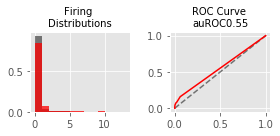

In [4]:
#import os

ratID = ['Amygdala3',
         'Amygdala6',
         'Amygdala8',
         'Amygdala10',
         'Amygdala11']
date = ['05052018', '13042019','01102019',
        '27062020', '06072020']
drive = 'F:/'

for i, rat in enumerate(ratID):
    
    neuronpath = drive+rat+'/Electrophys/'+date[i]+'/SpikeTimes/Neurons_Str/'
    print(neuronpath)
    
    try:
        neurondir = os.listdir(neuronpath)
        print('yes')
    except:
        continue
    
    savepath = drive+rat+'/Analyses/'+date[i]+'/ROC_Str/'
    run_roc(savepath, drive, rat, date[i], neuronpath)

F:/Amygdala3/Electrophys/05052018/SpikeTimes/Neurons_BA/
yes
F:/Amygdala6/Electrophys/13042019/SpikeTimes/Neurons_BA/
yes
F:/Amygdala6/Electrophys/14042019/SpikeTimes/Neurons_BA/
yes
F:/Amygdala8/Electrophys/01102019/SpikeTimes/Neurons_BA/
F:/Amygdala8/Electrophys/02102019/SpikeTimes/Neurons_BA/
F:/Amygdala10/Electrophys/27062020/SpikeTimes/Neurons_BA/
yes
F:/Amygdala10/Electrophys/28062020/SpikeTimes/Neurons_BA/
yes
F:/Amygdala11/Electrophys/06072020/SpikeTimes/Neurons_BA/
yes
F:/Amygdala11/Electrophys/07072020/SpikeTimes/Neurons_BA/
yes


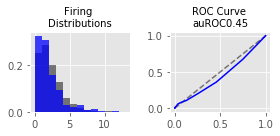

In [14]:
for i, rat in enumerate(ratID):
    
    neuronpath = drive+rat+'/Electrophys/'+date[i]+'/SpikeTimes/Neurons_BA/'
    print(neuronpath)
    
    try:
        neurondir = os.listdir(neuronpath)
        print('yes')
    except:
        continue
    
    savepath = drive+rat+'/Analyses/'+date[i]+'/ROC_BA/'
    run_roc(savepath, drive, rat, date[i], neuronpath)

F:/Amygdala3/Electrophys/05052018/SpikeTimes/Neurons_LA/
yes
F:/Amygdala6/Electrophys/13042019/SpikeTimes/Neurons_LA/
F:/Amygdala6/Electrophys/14042019/SpikeTimes/Neurons_LA/
F:/Amygdala8/Electrophys/01102019/SpikeTimes/Neurons_LA/
yes
F:/Amygdala8/Electrophys/02102019/SpikeTimes/Neurons_LA/
yes
F:/Amygdala10/Electrophys/27062020/SpikeTimes/Neurons_LA/
F:/Amygdala10/Electrophys/28062020/SpikeTimes/Neurons_LA/
F:/Amygdala11/Electrophys/06072020/SpikeTimes/Neurons_LA/
yes
F:/Amygdala11/Electrophys/07072020/SpikeTimes/Neurons_LA/
yes


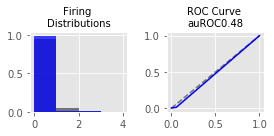

In [15]:
for i, rat in enumerate(ratID):
    
    neuronpath = drive+rat+'/Electrophys/'+date[i]+'/SpikeTimes/Neurons_LA/'
    print(neuronpath)
    
    try:
        neurondir = os.listdir(neuronpath)
        print('yes')
    except:
        continue
    
    savepath = drive+rat+'/Analyses/'+date[i]+'/ROC_LA/'
    run_roc(savepath, drive, rat, date[i], neuronpath)